**Problem Statement:**

---

In the context of email filtering, we aim to develop a model that can accurately classify incoming emails as either "phishing" (spam) or "legitimate" (ham).

Phishing emails are **malicious attempts** to obtain sensitive information such as usernames, passwords, and credit card details by **disguising as a trustworthy entity**. Detecting phishing emails is crucial for **protecting users from fraud and cyber threats.**

Our goal is to build a binary classification model that can predict whether a new, unseen email is a phishing attempt (spam) or a legitimate email (ham).

In [269]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from statsmodels.api import add_constant, Logit
import statsmodels.api as sm
from nltk.corpus import stopwords  # The Natural Language Toolkit
# STOPWORDS are common words that are usually filtered out in the text processing and analysis because they are considered to be less informative.

In [270]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [271]:
# Define the path to the dataset on Google Drive
PATH ="/content/drive/MyDrive/Colab Notebooks/spam (1).csv" # Replace With Path in your system
df=pd.read_csv(PATH,encoding='ISO-8859-1')  # Load the dataset into a pandas DataFrame
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [272]:
df.describe()  # Describe the dataset to understand its statistical properties

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [273]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True) # Drop unnecessary columns
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [274]:
df.rename(columns={'v1': 'TARGET', 'v2': 'MESSAGE'}, inplace=True)  # Rename columns for better understanding

In [275]:
df.isnull().sum()  # Checking for Null Values

,0
TARGET,0
MESSAGE,0


In [276]:
df.duplicated().sum()  # Checking for Duplicates

403

In [277]:
df.drop_duplicates(inplace=True)  # Dropping the Duplicates
df.duplicated().sum()  # Verify that all duplicate rows have been dropped

0

In [278]:
encoder=LabelEncoder()
df['TARGET']=encoder.fit_transform(df['TARGET'])  # Encode the target variable (Ham/Spam) as numerical values
df.head()

,TARGET,MESSAGE
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


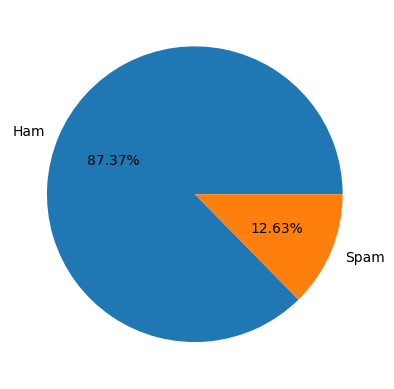

In [279]:
plt.pie(df['TARGET'].value_counts(), labels=['Ham', 'Spam'], autopct='%0.2f%%') # Plot the distribution of the target variable
plt.show()

In [280]:
# Splitting the Data into Training and Testing Sets
x = df['MESSAGE']
y = df['TARGET']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=3)

In [281]:
# Convert the text data into a matrix of token counts
cv=CountVectorizer()
x_train_cv=cv.fit_transform(x_train)
x_test_cv=cv.fit_transform(x_test)

In [282]:
# Initialize and train the logistic regression model
lr = LogisticRegression()
lr.fit(x_train_cv,y_train)
prediction_train=lr.predict(x_train_cv) # Fit the model on training data
print(f'Training Accuracy: {accuracy_score(y_train,prediction_train)*100:0.2f}%')

Training Accuracy: 99.76%


In [283]:
lr.fit(x_test_cv, y_test)  # Fit the model on the test data
prediction_test = lr.predict(x_test_cv) # Predict the test data
print(f'Testing Accuracy: {accuracy_score(y_test,prediction_test)*100:0.2f}%')

Testing Accuracy: 99.81%


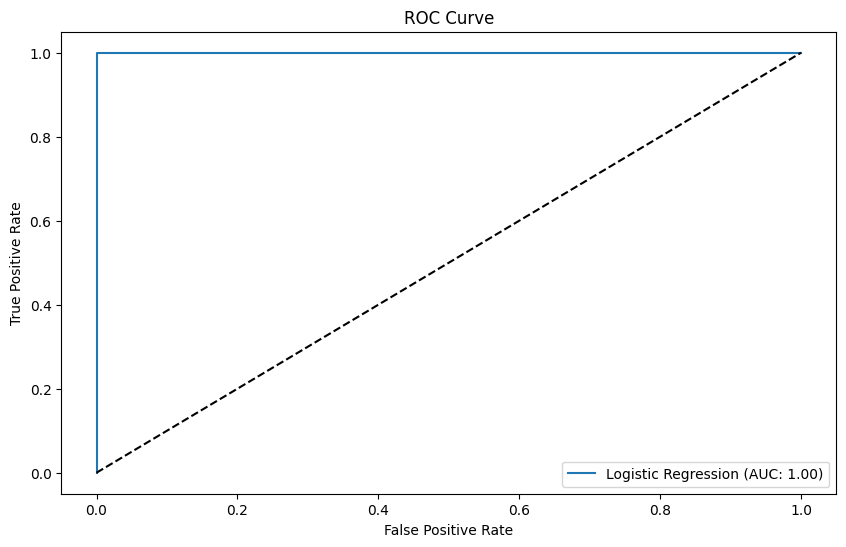

In [284]:
# Plot ROC Curve
y_pred_prob = lr.predict_proba(x_test_cv)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC: {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The ROC curve showing an AUC of 1.00 suggests that the logistic regression model is classifying the spam and ham emails perfectly on the test data, which is generally an indication of an overly optimistic result. To make sure that the model accuracy is not due to overfitting, we employ the K-fold Cross-Validation Technique - to access the model’s performance on different subsets of the data. This helps ensure that the model generalizes well to unseen data.

In [285]:
# Perform k-fold cross-validation to validate the model's performance
cv_scores = cross_val_score(lr, x_train_cv, y_train, cv=10)
print(f'Average Cross-Validation Accuracy: {cv_scores.mean()}')
print(f'This output indicates that {cv_scores.mean()*100:0.2f}% of times, on average, the logistic regression model correctly classifies emails in the cross-validation process.')

Average Cross-Validation Accuracy: 0.9794440350446246
This output indicates that 97.94% of times, on average, the logistic regression model correctly classifies emails in the cross-validation process.


To further access the model's accuracy we develop a Classification report that gives us various helpful insights of the model

In [286]:
# Generate and print a classification report
print("Classification Report:")
print(classification_report(y_test, prediction_test))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       894
           1       1.00      0.99      0.99       140

    accuracy                           1.00      1034
   macro avg       1.00      0.99      1.00      1034
weighted avg       1.00      1.00      1.00      1034



High Performance: The model shows exceptionally high performance with an overall accuracy of 100%, precision of 1.00 for both classes, and very high recall for both classes.
Class Imbalance Handling: Despite the class imbalance (more 'Ham' than 'Spam'), the model performs well for both classes.

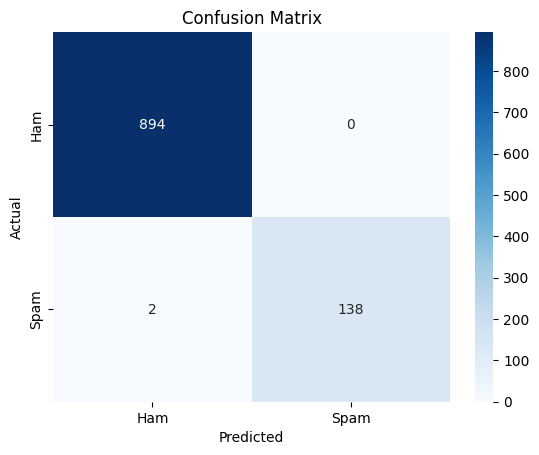

In [287]:
conf_matrix = confusion_matrix(y_test, prediction_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**True Positives**: The number of correct predictions that an instance is positive (Spam).In this case, the model correctly predicted 138 emails as 'Spam'.

**True Negatives**: The number of correct predictions that an instance is negative (Ham).In this case, the model correctly predicted 894 emails as 'Ham'.

**False Positives**: The number of incorrect predictions that an instance is positive (Spam).In this case, the model incorrectly predicted 0 emails as 'Spam' when they were actually 'Ham'.

**False Negatives**: The number of incorrect predictions that an instance is negative (Ham). In this case, the model incorrectly predicted 2 emails as 'Ham' when they were actually 'Spam'.

In [288]:
def predict_message(message):
    # Transform the message using the trained CountVectorizer
    message_cv = cv.transform([message])
    # Predict the class (Ham or Spam)
    prediction = lr.predict(message_cv)
    # Return the result
    return 'Spam' if prediction == 1 else 'Ham'

test_message = "Congratulations! You've won a free ticket to Bahamas. Call now to claim your prize."
print(f'The message: "{test_message}" is classified as: {predict_message(test_message)}')

The message: "Congratulations! You've won a free ticket to Bahamas. Call now to claim your prize." is classified as: Spam


**Conclusion**


---


These results, coupled with the ROC curve and classification report, provide a comprehensive evaluation of the logistic regression model’s performance on the email classification task.